<a href="https://colab.research.google.com/github/fnovoas/sinrepco/blob/main/Sinrepco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SINREPCO
por fnovoas@unal.edu.co

Para cargar un modelo de Sinrepco ya hecho (entrenado), saltamos directamente al **paso 8**. Podemos evaluarlo en el **paso 6**.

1. Instalamos las bibliotecas necesarias: TensorFlow para el desarrollo de modelos de inteligencia artificial, OpenCV para el procesamiento de imágenes y Tesseract para el reconocimiento óptico de caracteres (OCR).

In [37]:
!pip install tensorflow opencv-python pytesseract

2. Procedemos con la recolección de datos, reunimos un conjunto de datos que contiene imágenes de vehículos, tanto contaminantes como no contaminantes, estas imágenes fueron capturadas por mí en diversas ubicaciones. Contamos con 3396 imágenes de vehículos no chimenea y 298 imágenes de vehículos chimenea.
Separamos las imágenes según si contienen vehículos que emiten humo visible o no, en dos carpetas: "chimenea" y "no_chimenea". Con estos datos entrenaremos al modelo.\
Montamos Drive para acceder a las imágenes.

In [38]:
from google.colab import drive
import os

# Montar el Google Drive
drive.mount('/content/drive')

# Directorio base donde está la carpeta "sinrepco_fotos"
base_dir = "/content/drive/My Drive/sinrepco_fotos"

# Función para contar archivos en una carpeta
def contar_archivos_en_carpeta(carpeta):
    return len([f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))])

# Recorrer todas las carpetas y subcarpetas en el directorio base
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        carpeta_actual = os.path.join(root, dir_name)
        num_archivos = contar_archivos_en_carpeta(carpeta_actual)
        print(f"Carpeta encontrada: {carpeta_actual} - Archivos: {num_archivos}")

# Función para cambiar extensión .JPG a .jpg
def cambiar_extensiones_a_minusculas(carpeta):
    for filename in os.listdir(carpeta):
        if filename.endswith(".JPG"):
            os.rename(os.path.join(carpeta, filename), os.path.join(carpeta, filename.lower()))

# Verificar si existe la carpeta 'train' en la raíz
if os.path.exists(f'{base_dir}/train'):
    # Aplicar cambio de extensiones a las subcarpetas dentro de 'train'
    cambiar_extensiones_a_minusculas(f'{base_dir}/train/chimenea')
    cambiar_extensiones_a_minusculas(f'{base_dir}/train/no_chimenea')
    # Verificar cuántas imágenes hay en cada subcarpeta dentro de 'train'
    print("Extensión de archivos cambiada de .JPG a .jpg")
    print(f"Imágenes en train/chimenea: {len(os.listdir(f'{base_dir}/train/chimenea'))}")
    print(f"Imágenes en train/no_chimenea: {len(os.listdir(f'{base_dir}/train/no_chimenea'))}")
else:
    # Aplicar cambio de extensiones en la raíz
    cambiar_extensiones_a_minusculas(f'{base_dir}/chimenea')
    cambiar_extensiones_a_minusculas(f'{base_dir}/no_chimenea')
    # Verificar cuántas imágenes hay en cada carpeta en la raíz
    print("Extensión de archivos cambiada de .JPG a .jpg")
    print(f"Imágenes en chimenea: {len(os.listdir(f'{base_dir}/chimenea'))}")
    print(f"Imágenes en no_chimenea: {len(os.listdir(f'{base_dir}/no_chimenea'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/no_chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/chimenea - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test - Archivos: 0
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/chimenea - Archivos: 208
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/train/no_chimenea - Archivos: 2377
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/chimenea - Archivos: 44
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/validation/no_chimenea - Archivos: 509
Carpeta encontrada: /content/drive/My Drive/sinrepco_fotos/test/chimenea - Archivos: 46

In [39]:
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


3. 3.a. **(Solo hace falta ejecutar este código cada vez que incorporemos nuevos datos, al hacerlo, deben estar guardados en las carpetas originales "chimenea" y "no_chimenea" en el directorio raíz respectivamente)** Cargamos y preparamos los datos de la carpeta en donde están almacenados en Drive. Este código divide las imágenes en conjuntos de entrenamiento, validación y prueba según el porcentaje especificado: el 70% de los datos irán en entrenamiento y el 15% en cada una de las otras dos categorías. Ejecutar este código cambia la estructura de la organización de los archivos y carpetas en Drive (el cambio tarda unos minutos en reflejarse en Drive).

In [ ]:
import os
import random
import shutil
import time
# Crear directorios si no existen
base_dir = '/content/drive/My Drive/sinrepco_fotos'
source_chimenea = f'{base_dir}/chimenea'
source_no_chimenea = f'{base_dir}/no_chimenea'

train_chimenea_dir = f'{base_dir}/train/chimenea'
val_chimenea_dir = f'{base_dir}/validation/chimenea'
test_chimenea_dir = f'{base_dir}/test/chimenea'

train_no_chimenea_dir = f'{base_dir}/train/no_chimenea'
val_no_chimenea_dir = f'{base_dir}/validation/no_chimenea'
test_no_chimenea_dir = f'{base_dir}/test/no_chimenea'

os.makedirs(train_chimenea_dir, exist_ok=True)
os.makedirs(val_chimenea_dir, exist_ok=True)
os.makedirs(test_chimenea_dir, exist_ok=True)
os.makedirs(train_no_chimenea_dir, exist_ok=True)
os.makedirs(val_no_chimenea_dir, exist_ok=True)
os.makedirs(test_no_chimenea_dir, exist_ok=True)

def move_files(files, source, destination):
    for f in files:
        src_path = os.path.join(source, f)
        dest_path = os.path.join(destination, f)
        shutil.move(src_path, dest_path)
        # Verifica si el archivo se movió correctamente
        if not os.path.exists(dest_path):
            print(f"Reintentando mover: {f}")
            shutil.move(src_path, dest_path)
            # Da tiempo al sistema para procesar la operación
            time.sleep(0.1)

def move_data(SOURCE, TRAINING, VALIDATION, TEST, split_train=0.7, split_val_test=0.15):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    print(f"Total de archivos encontrados en {SOURCE}: {len(files)}")  # Imprime el número total de archivos encontrados

    random.shuffle(files)

    train_size = int(len(files) * split_train)
    val_size = int(len(files) * split_val_test)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    print(f"Moviendo {len(train_files)} archivos a {TRAINING}")  # Imprime cuántos archivos se moverán al entrenamiento
    print(f"Moviendo {len(val_files)} archivos a {VALIDATION}")  # Imprime cuántos archivos se moverán a validación
    print(f"Moviendo {len(test_files)} archivos a {TEST}")  # Imprime cuántos archivos se moverán a prueba

    # Mueve los archivos en lotes para evitar problemas con demasiadas operaciones a la vez
    batch_size = 100  # Ajusta este tamaño según sea necesario
    for i in range(0, len(train_files), batch_size):
        move_files(train_files[i:i+batch_size], SOURCE, TRAINING)

    for i in range(0, len(val_files), batch_size):
        move_files(val_files[i:i+batch_size], SOURCE, VALIDATION)

    for i in range(0, len(test_files), batch_size):
        move_files(test_files[i:i+batch_size], SOURCE, TEST)

# Ejecutar esta función para cada clase
move_data(source_chimenea, train_chimenea_dir, val_chimenea_dir, test_chimenea_dir)
move_data(source_no_chimenea, train_no_chimenea_dir, val_no_chimenea_dir, test_no_chimenea_dir)

3.a.1. Creamos una subcarpeta adicional dentro de cada una de las subcarpetas "chimenea" y "no_chimenea" de la carpeta "train", y movemos las imágenes ahí. Esto es para que la función flow_from_directory pueda leer los archivos.

In [41]:
# Crear una estructura de subcarpetas para chimenea y no_chimenea
import os
import shutil

# Crear subcarpeta dentro de chimenea
os.makedirs(f'{base_dir}/train/chimenea/clase_chimenea', exist_ok=True)
for filename in os.listdir(f'{base_dir}/train/chimenea'):
    if filename != 'clase_chimenea':  # Evitar mover la subcarpeta recién creada
        shutil.move(os.path.join(f'{base_dir}/train/chimenea', filename), os.path.join(f'{base_dir}/train/chimenea/clase_chimenea', filename))

# Crear subcarpeta dentro de no_chimenea
os.makedirs(f'{base_dir}/train/no_chimenea/clase_no_chimenea', exist_ok=True)
for filename in os.listdir(f'{base_dir}/train/no_chimenea'):
    if filename != 'clase_no_chimenea':  # Evitar mover la subcarpeta recién creada
        shutil.move(os.path.join(f'{base_dir}/train/no_chimenea', filename), os.path.join(f'{base_dir}/train/no_chimenea/clase_no_chimenea', filename))

3.b. Después de dividir los datos, configuramos el ImageDataGenerator para cargar las imágenes de estas nuevas carpetas.  
**Actualización**: para compensar la falta de fotos en la carpeta chimenea, usaremos aumento de datos en la clase minoritaria (chimenea) para generar nuevas imágenes variadas de forma sintética. Usamos rotaciones, zoom, traslaciones, cambios de brillo, entre otros.
Naturalmente, revertiremos este cambio una vez que hayamos aumentado la cantidad de datos de vehículos chimenea (esto es, cuando les tome más fotos), y no dejaremos imágenes generadas sintéticamente.

In [43]:
#importamos las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import the ImageDataGenerator class
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
# Parámetros (reducir estos valores si nos quedamos sin RAM)
IMG_HEIGHT = 450
IMG_WIDTH = 600
BATCH_SIZE = 8

# Aumento de datos para la clase chimenea
chimenea_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Sin aumento de datos para la clase no_chimenea
no_chimenea_datagen = ImageDataGenerator(rescale=1./255)

# Generador para la clase chimenea
chimenea_generator = chimenea_datagen.flow_from_directory(
    f'{base_dir}/train/chimenea',  # Apuntar a la carpeta "chimenea"
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Generador para la clase no_chimenea
no_chimenea_generator = no_chimenea_datagen.flow_from_directory(
    f'{base_dir}/train/no_chimenea',  # Apuntar a la carpeta "no_chimenea"
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)
# Verificar el generador de la clase chimenea
chimenea_images, chimenea_labels = next(chimenea_generator)
print(f'Imágenes de chimenea: {chimenea_images.shape}')
print(f'Etiquetas de chimenea: {chimenea_labels.shape}')

# Verificar el generador de la clase no_chimenea
no_chimenea_images, no_chimenea_labels = next(no_chimenea_generator)
print(f'Imágenes de no_chimenea: {no_chimenea_images.shape}')
print(f'Etiquetas de no_chimenea: {no_chimenea_labels.shape}')

# Combinar los generadores
def combined_generator(chimenea_gen, no_chimenea_gen):
    while True:
        chimenea_batch = next(chimenea_gen)
        no_chimenea_batch = next(no_chimenea_gen)
        combined_images = np.concatenate((chimenea_batch[0], no_chimenea_batch[0]))
        combined_labels = np.concatenate((chimenea_batch[1], no_chimenea_batch[1]))
        yield combined_images, combined_labels

# Generador combinado para entrenamiento
train_generator = combined_generator(chimenea_generator, no_chimenea_generator)

# Generador de validación (sin aumento)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    f'{base_dir}/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Generador de prueba (sin aumento)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
# Verificar el generador de prueba
test_images, test_labels = next(test_generator)
print(f'Imágenes: {test_images.shape}')
print(f'Etiquetas: {test_labels.shape}')

Found 208 images belonging to 1 classes.
Found 2377 images belonging to 1 classes.
Imágenes de chimenea: (8, 450, 600, 3)
Etiquetas de chimenea: (8,)
Imágenes de no_chimenea: (8, 450, 600, 3)
Etiquetas de no_chimenea: (8,)
Found 553 images belonging to 2 classes.
Found 556 images belonging to 2 classes.
Imágenes: (8, 450, 600, 3)
Etiquetas: (8,)


4. Ahora definimos la arquitectura de la CNN. Tomamos una estructura de red neuronal convolucional, que es adecuada para el análisis de imágenes.

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# Definir la arquitectura de la CNN
model = Sequential([
    Input(shape=(450, 600, 3)),  # Especificamos la forma de entrada aquí
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

5. **Entrenamos** el modelo. Si bien el número de épocas recomendado normalmente (el número de veces que el modelo recorre todo el conjunto de datos para entrenarse) es de 20, usamos 5 para ajustarnos con el tiempo de ejecución máximo disponible (*ejecutar este código puede tomar de 2 a 11 horas, como se ha visto en diferentes iteraciones*).
**Actualización**: añadimos el parámetro steps_per_epoch para que se generen nuevas imágenes de la clase "chimenea" como explicamos en el punto 3.b.

In [45]:
EPOCHS = 5

# Calcular steps_per_epoch
total_chimenea = chimenea_generator.samples
total_no_chimenea = no_chimenea_generator.samples
total_images_in_train = total_chimenea + total_no_chimenea
steps_per_epoch = 100  # Reducido temporalmente para depuración

# Verificar el generador de la clase chimenea
chimenea_images, chimenea_labels = next(chimenea_generator)
print(f'Imágenes de chimenea: {chimenea_images.shape}')
print(f'Etiquetas de chimenea: {chimenea_labels.shape}')

# Verificar el generador de la clase no_chimenea
no_chimenea_images, no_chimenea_labels = next(no_chimenea_generator)
print(f'Imágenes de no_chimenea: {no_chimenea_images.shape}')
print(f'Etiquetas de no_chimenea: {no_chimenea_labels.shape}')

# Verificar lo que genera el train_generator
images, labels = next(train_generator)
print(f'Imágenes: {images.shape}')
print(f'Etiquetas: {labels.shape}')
print(f'Primera etiqueta: {labels[0]}')

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS
)

Imágenes de chimenea: (8, 450, 600, 3)
Etiquetas de chimenea: (8,)
Imágenes de no_chimenea: (8, 450, 600, 3)
Etiquetas de no_chimenea: (8,)
Imágenes: (16, 450, 600, 3)
Etiquetas: (16,)
Primera etiqueta: 0.0
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9870 - loss: 0.0350 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1752s 17s/step - accuracy: 0.9871 - loss: 0.0347 - val_accuracy: 0.0796 - val_loss: 3483.2290
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1675s 17s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.0796 - val_loss: 3483.6296
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1686s 17s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.0796 - val_loss: 3483.6296
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1692s 17s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.0796 - val_loss: 3483.6296
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1685s 17s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.0796 - val_loss: 3483.6299


6. **Evaluamos** el modelo.
6.a. Gráficas de pérdida y precisión (*accuracy*).

70/70 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2781 - loss: 2693.9189
Loss: 3506.98486328125
Accuracy: 0.08273380994796753


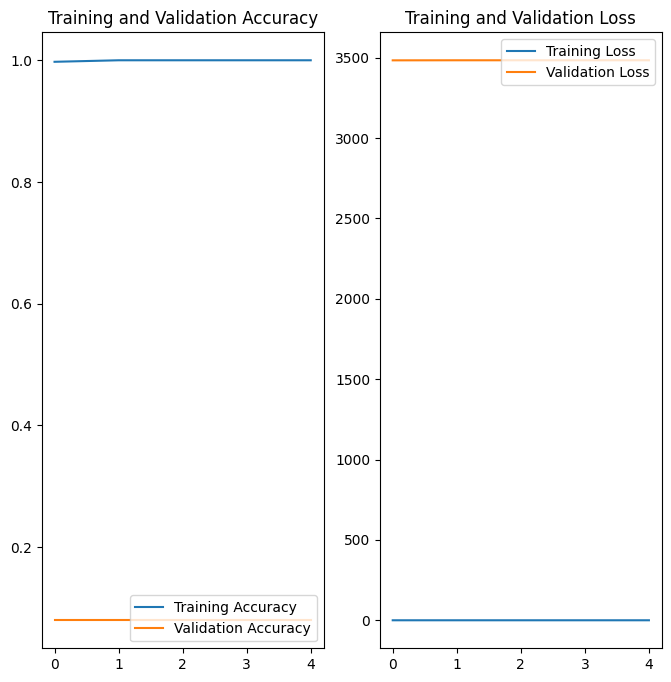

In [46]:
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Graficar los resultados del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6.b. Gráfica de matriz de confusión.

70/70 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step


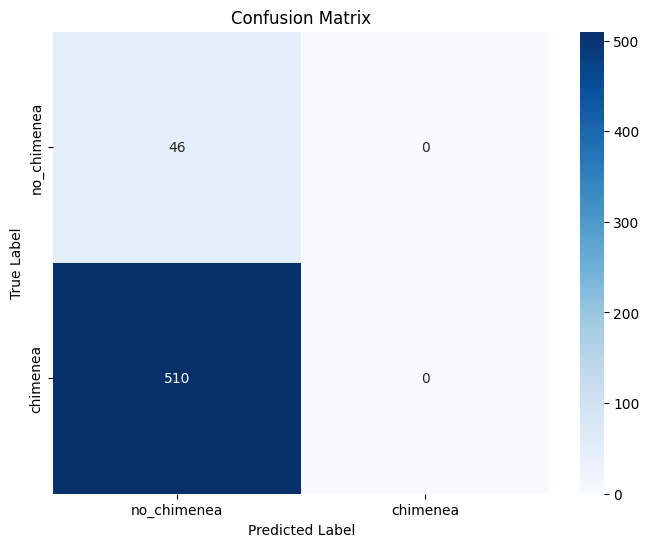

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones del conjunto de prueba
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int).flatten()  # Redondear a 0 o 1

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['no_chimenea', 'chimenea']

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

6.c. Curvas ROC y AUC.

70/70 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step


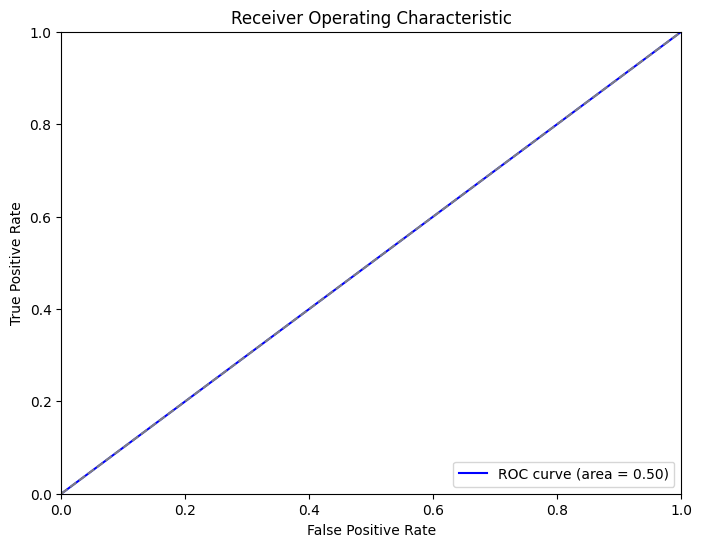

In [48]:
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades predichas
y_pred_prob = model.predict(test_generator).flatten()

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

6.d. Reporte de clasificación.

In [49]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 no_chimenea       0.08      1.00      0.15        46
    chimenea       0.00      0.00      0.00       510

    accuracy                           0.08       556
   macro avg       0.04      0.50      0.08       556
weighted avg       0.01      0.08      0.01       556



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6.e. Curvas de pérdida y precisión **por época**.

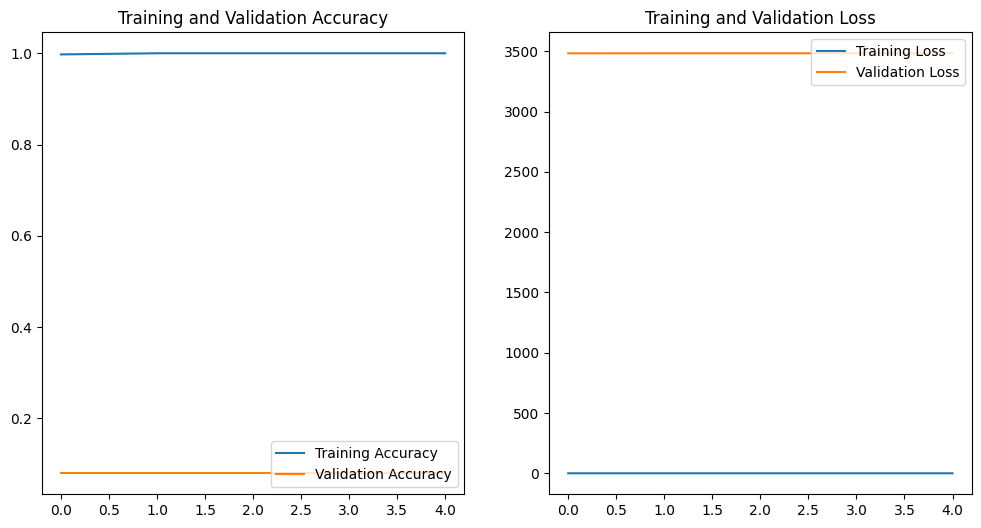

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6.f. Gráfica de Precision-Recall

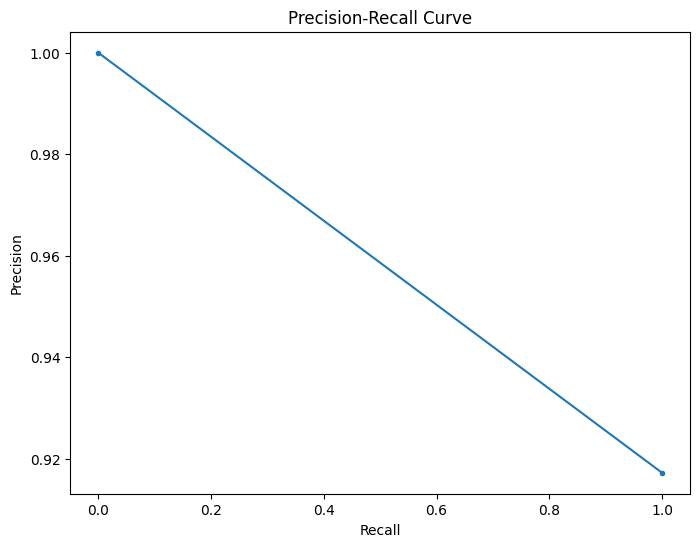

In [51]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

7. **Guardar** el modelo ya entrenado en Drive (para no tener que ejecutar el paso 5 nuevamente). *Tamaño del modelo actual: 2.89 GB*.

In [ ]:
# Guardar el modelo en formato Keras nativo en la carpeta sinrepco_fotos en Drive
model_path = '/content/drive/My Drive/sinrepco_fotos/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)


7.a. Descargar el modelo en el equipo local (más demorado).

In [ ]:
# Guardar el modelo en formato Keras nativo en el almacenamiento local de Colab
model_path = '/content/saved_model.keras'

# Guardar el modelo entrenado en la ruta especificada
model.save(model_path)

# Descargar el modelo a tu equipo
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8. **Cargar** el modelo a la sesión actual (para usar un modelo guardado anteriormente).

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/My Drive/sinrepco_fotos/saved_model.keras')

# A continuación
Deberemos desarrollar el subsistema de reconocimiento de placas vehiculares. Para un futuro avance, deberemos integrar los dos subsistemas y desarrollar la función de publicación automatizada en X (antes Twitter).
Gracias por leer.